In [1]:
from pathlib import Path
import re
import pandas as pd

# =========================
# 0) 경로 설정 (폴더 규칙 반영)
# =========================
project_root = Path.cwd().parent          # LimSeungHyeon 폴더 기준 -> project 루트
data_dir = project_root / "data"

file_list = sorted(data_dir.glob("*.csv"))
print("project_root:", project_root.resolve())
print("data_dir:", data_dir.resolve())
print("found_files:", [f.name for f in file_list])

# =========================
# 1) 표준 스키마 정의
# =========================
STANDARD_COLUMNS = [
    "country",
    "rank",
    "score",
    "gdp_per_capita",
    "social_support",
    "healthy_life_expectancy",
    "freedom",
    "generosity",
    "perceptions_of_corruption",
    "year",
]

# =========================
# 2) 컬럼명 정규화 도우미
#    - 공백/특수문자 제거
#    - 소문자 통일
# =========================
def normalize_column_name(column_name: str) -> str:
    name = column_name.strip().lower()
    name = name.replace("\ufeff", "")  # BOM 제거
    name = re.sub(r"[^\w\s]", " ", name)  # 특수문자 -> 공백
    name = re.sub(r"\s+", " ", name).strip()
    return name


# =========================
# 3) 연도별 "다른 표기"를 표준 컬럼으로 매핑(핵심)
#    - 키워드 기반으로 최대한 자동 매칭
# =========================
def build_column_mapping(columns: list[str]) -> dict[str, str]:
    normalized = {c: normalize_column_name(c) for c in columns}

    mapping = {}

    def map_if_contains(original_col: str, keywords: list[str], target: str) -> bool:
        col_norm = normalized[original_col]
        return all(k in col_norm for k in keywords) and (mapping.get(original_col) is None) and (target not in mapping.values())

    for original_col in columns:
        col_norm = normalized[original_col]

        # country
        if ("country" in col_norm) or ("region" in col_norm and "country" in col_norm) or (col_norm == "country") or ("country name" in col_norm):
            mapping[original_col] = "country"
            continue

        # rank
        if ("rank" in col_norm) or ("overall rank" in col_norm):
            mapping[original_col] = "rank"
            continue

        # score (happiness score / ladder score / score)
        if ("score" in col_norm) or ("ladder" in col_norm):
            mapping[original_col] = "score"
            continue

        # gdp per capita
        if ("gdp" in col_norm and "capita" in col_norm) or ("economy" in col_norm and "gdp" in col_norm):
            mapping[original_col] = "gdp_per_capita"
            continue
        if col_norm == "economy gdp per capita":
            mapping[original_col] = "gdp_per_capita"
            continue

        # social support (family)
        if ("social support" in col_norm) or (col_norm == "family"):
            mapping[original_col] = "social_support"
            continue

        # healthy life expectancy
        if ("healthy" in col_norm and "life" in col_norm) or ("health" in col_norm and "life" in col_norm):
            mapping[original_col] = "healthy_life_expectancy"
            continue

        # freedom
        if "freedom" in col_norm:
            mapping[original_col] = "freedom"
            continue

        # generosity
        if "generosity" in col_norm:
            mapping[original_col] = "generosity"
            continue

        # perceptions of corruption (trust)
        if ("corruption" in col_norm) or ("trust" in col_norm and "government" in col_norm) or ("perceptions" in col_norm and "corruption" in col_norm):
            mapping[original_col] = "perceptions_of_corruption"
            continue

    return mapping


# =========================
# 4) 단일 파일 로드 + 표준화 함수
# =========================
def load_and_standardize_csv(file_path: Path) -> pd.DataFrame:
    year = int(file_path.stem)

    raw_df = pd.read_csv(file_path)

    # 컬럼 매핑 생성
    column_mapping = build_column_mapping(raw_df.columns.tolist())
    standardized_df = raw_df.rename(columns=column_mapping).copy()

    # year 추가
    standardized_df["year"] = year

    # 표준 컬럼 중 없는 컬럼은 생성(결측으로)
    for col in STANDARD_COLUMNS:
        if col not in standardized_df.columns:
            standardized_df[col] = pd.NA

    # 표준 컬럼만 남기고 순서 고정
    standardized_df = standardized_df[STANDARD_COLUMNS]

    # 숫자 컬럼 형변환(가능한 것들은 숫자로)
    numeric_targets = [
        "rank",
        "score",
        "gdp_per_capita",
        "social_support",
        "healthy_life_expectancy",
        "freedom",
        "generosity",
        "perceptions_of_corruption",
        "year",
    ]
    for col in numeric_targets:
        standardized_df[col] = pd.to_numeric(standardized_df[col], errors="coerce")

    # country 문자열 정리
    standardized_df["country"] = standardized_df["country"].astype("string").str.strip()

    return standardized_df


# =========================
# 5) 전체 로드 + 통합
# =========================
dataframe_list = []
for file_path in file_list:
    temp_df = load_and_standardize_csv(file_path)
    dataframe_list.append(temp_df)

happiness_df = pd.concat(dataframe_list, ignore_index=True)

happiness_df.head()

project_root: C:\Project
data_dir: C:\Project\data
found_files: ['2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv', '2020.csv', '2021.csv', '2022.csv', '2023.csv', '2024.csv']


,country,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,perceptions_of_corruption,year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015


In [2]:
# 연도별 결측/스키마 상태 체크
schema_check_df = (
    happiness_df
    .groupby("year")
    .agg(
        rows=("country", "count"),
        missing_country=("country", lambda s: s.isna().sum()),
        missing_score=("score", lambda s: s.isna().sum()),
        missing_rank=("rank", lambda s: s.isna().sum()),
    )
)

schema_check_df

,rows,missing_country,missing_score,missing_rank
year,,,,
2015,158,0,0,0
2016,157,0,0,0
2017,155,0,0,0
2018,156,0,0,0
2019,156,0,0,0
2020,153,0,0,0
2021,149,0,0,0
2022,146,0,0,0
2023,137,0,0,0


In [3]:
happiness_df.isna().mean().sort_values(ascending=False)

perceptions_of_corruption    0.002649
healthy_life_expectancy      0.002649
generosity                   0.001987
freedom                      0.001987
social_support               0.001987
gdp_per_capita               0.001987
rank                         0.000000
country                      0.000000
score                        0.000000
year                         0.000000
dtype: float64

In [4]:
happiness_df.shape
happiness_df.info()happiness_df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1510 non-null   string 
 1   rank                       1510 non-null   int64  
 2   score                      1510 non-null   float64
 3   gdp_per_capita             1507 non-null   float64
 4   social_support             1507 non-null   float64
 5   healthy_life_expectancy    1506 non-null   float64
 6   freedom                    1507 non-null   float64
 7   generosity                 1507 non-null   float64
 8   perceptions_of_corruption  1506 non-null   float64
 9   year                       1510 non-null   int64  
dtypes: float64(7), int64(2), string(1)
memory usage: 118.1 KB


perceptions_of_corruption    4
healthy_life_expectancy      4
generosity                   3
freedom                      3
social_support               3
gdp_per_capita               3
rank                         0
country                      0
score                        0
year                         0
dtype: int64

In [6]:
numeric_summary_df = happiness_df.describe(include="number").T

text_columns = happiness_df.select_dtypes(include=["object", "string"]).columns
text_summary_df = happiness_df[text_columns].describe().T

yearly_mean_df = happiness_df.groupby("year").mean(numeric_only=True)

numeric_summary_df.head(), text_summary_df.head(), yearly_mean_df.head()





(                          count       mean        std    min        25%  \
 rank                     1510.0  76.144371  43.850630  1.000  38.000000   
 score                    1510.0   5.449274   1.122885  1.721   4.603500   
 gdp_per_capita           1507.0   1.052821   0.462911  0.000   0.740685   
 social_support           1507.0   1.053570   0.332261  0.000   0.841210   
 healthy_life_expectancy  1506.0   0.578193   0.239482  0.000   0.401490   
 
                                50%        75%      max  
 rank                     76.000000  114.00000  158.000  
 score                     5.472000    6.26900    7.842  
 gdp_per_capita            1.070000    1.37350    2.209  
 social_support            1.093000    1.31813    1.644  
 healthy_life_expectancy   0.602185    0.76000    1.141  ,
         count unique          top freq
 country  1510    198  Switzerland   10,
            rank     score  gdp_per_capita  social_support  \
 year                                             

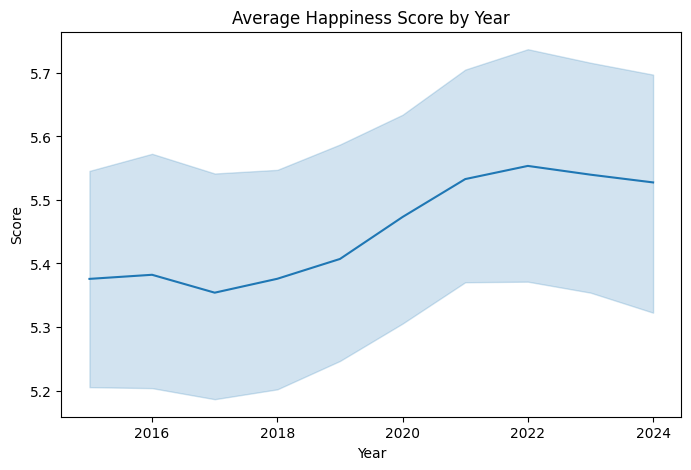

In [11]:
happiness_df.groupby("year")["score"].mean()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(data=happiness_df, x="year", y="score", estimator="mean")
plt.title("Average Happiness Score by Year")
plt.xlabel("Year")
plt.ylabel("Score")
plt.show()

In [12]:
corr_df = happiness_df.corr(numeric_only=True)
corr_df["score"].sort_values(ascending=False)

score                        1.000000
gdp_per_capita               0.713724
healthy_life_expectancy      0.679125
social_support               0.663865
freedom                      0.557326
perceptions_of_corruption    0.419513
generosity                   0.081295
year                         0.061730
rank                        -0.985148
Name: score, dtype: float64

In [13]:
happiness_df.groupby("year")["score"].mean()

year
2015    5.375734
2016    5.382185
2017    5.354019
2018    5.375917
2019    5.407096
2020    5.473203
2021    5.532839
2022    5.553575
2023    5.539796
2024    5.527580
Name: score, dtype: float64

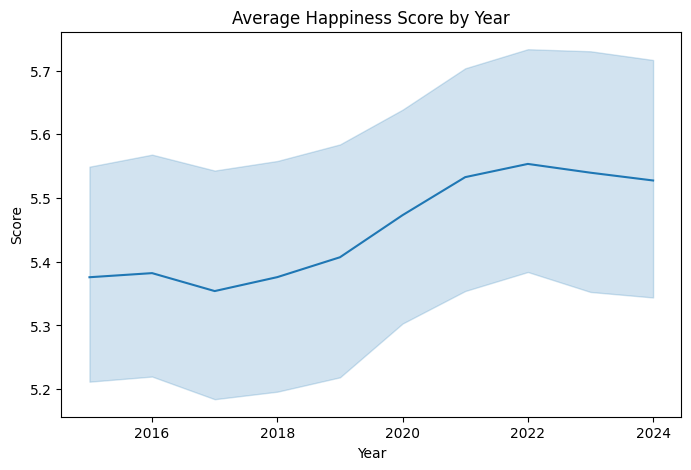

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(data=happiness_df, x="year", y="score", estimator="mean")
plt.title("Average Happiness Score by Year")
plt.xlabel("Year")
plt.ylabel("Score")
plt.show()